> # **`Project Serenity`**

 A project to compare a gradient descent ensemble boosted tree (regressor!) to `Forecaster`.

In [5]:
from serenity import read_data, pipelines, permutations, compare_predict_vs_test
from xgboost import plot_tree, plot_importance
import matplotlib.pyplot as plt
from random import randrange
import pandas as pd
%config InlineBackend.figure_format ='retina'
import sys, os

class suppress_print():
    def __enter__(self):
        self.original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self.original_stdout

# Dataset
- Dataset acquired from the [`NASA Exoplanet Archive`](https://exoplanetarchive.ipac.caltech.edu)
- `ML_nasa_tess_viable` is a collection of all exoplanets with a TESS data product.

In [6]:
raw_data = pd.read_csv('data/ML_nasa_tess_viable.csv.xz', low_memory=False)

# Model: `XGBRegressor()`
- Test-Train splits have a test size of `0.2`.
- Data leakage accounted for with piplines handling preprocessing before cross-validation.
- Capable of handling categorical or numerical columns.
- Categorical uses `OneHotEncoder()` and the most frequent string if there are missing values using `SimpleImputer()`.
- Numerical preprocessing steps use the `RobustScalar()` method and a mean strategy using `SimpleImputer()`.
- Need to investigate why `count:possion` gives the best accuracy.

In [7]:
hyper_parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
                    'objective':['count:poisson'],#['reg:squarederror'],['count:poisson']['reg:squaredlogerror']
                    'learning_rate': [0.05], #so called `eta` value
                    'max_depth': [5,6,7],
                    'min_child_weight': [0,0.1],
                    'subsample': [0.2],
                    'colsample_bytree': [1],
                    'n_estimators': [500,]}


features = ['pl_radj', 'glat', 'glon', 'elat', 'elon', 'sy_dist', 'disc_year', 'st_age', 'st_teff', 'pl_orblper', 'pl_tranmid', 'pl_orbper', 'sy_w3mag', 'sy_w2mag', 'sy_w1mag', 'sy_w4mag', 'sy_gaiamag', 'sy_tmag', 'sy_kepmag',  'ima_flag']
# features = ['pl_radj']
objective = 'pl_massj'
override = False
random_seed = 1# randrange(100)
X_train, X_test, y_train, y_test, X, y = read_data('data/ML_nasa_tess_viable.csv.xz', objective, features, seed=random_seed, override_features=override)
# X_train, X_test, y_train, y_test, X, y = read_data('data/nasa_full.csv.xz', objective, features, seed=3)
# X_train, X_test, y_train, y_test, X, y = read_data('data/kep.csv.gz', objective, features, override_features=override)

clf, y_pred = pipelines(hyper_parameters, seed=random_seed)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
MAE: 0.5926
Accuracy: 67.89%


# `Feature Exploration`
- Display a node from the model, and general feature importance contributing to our predictions.

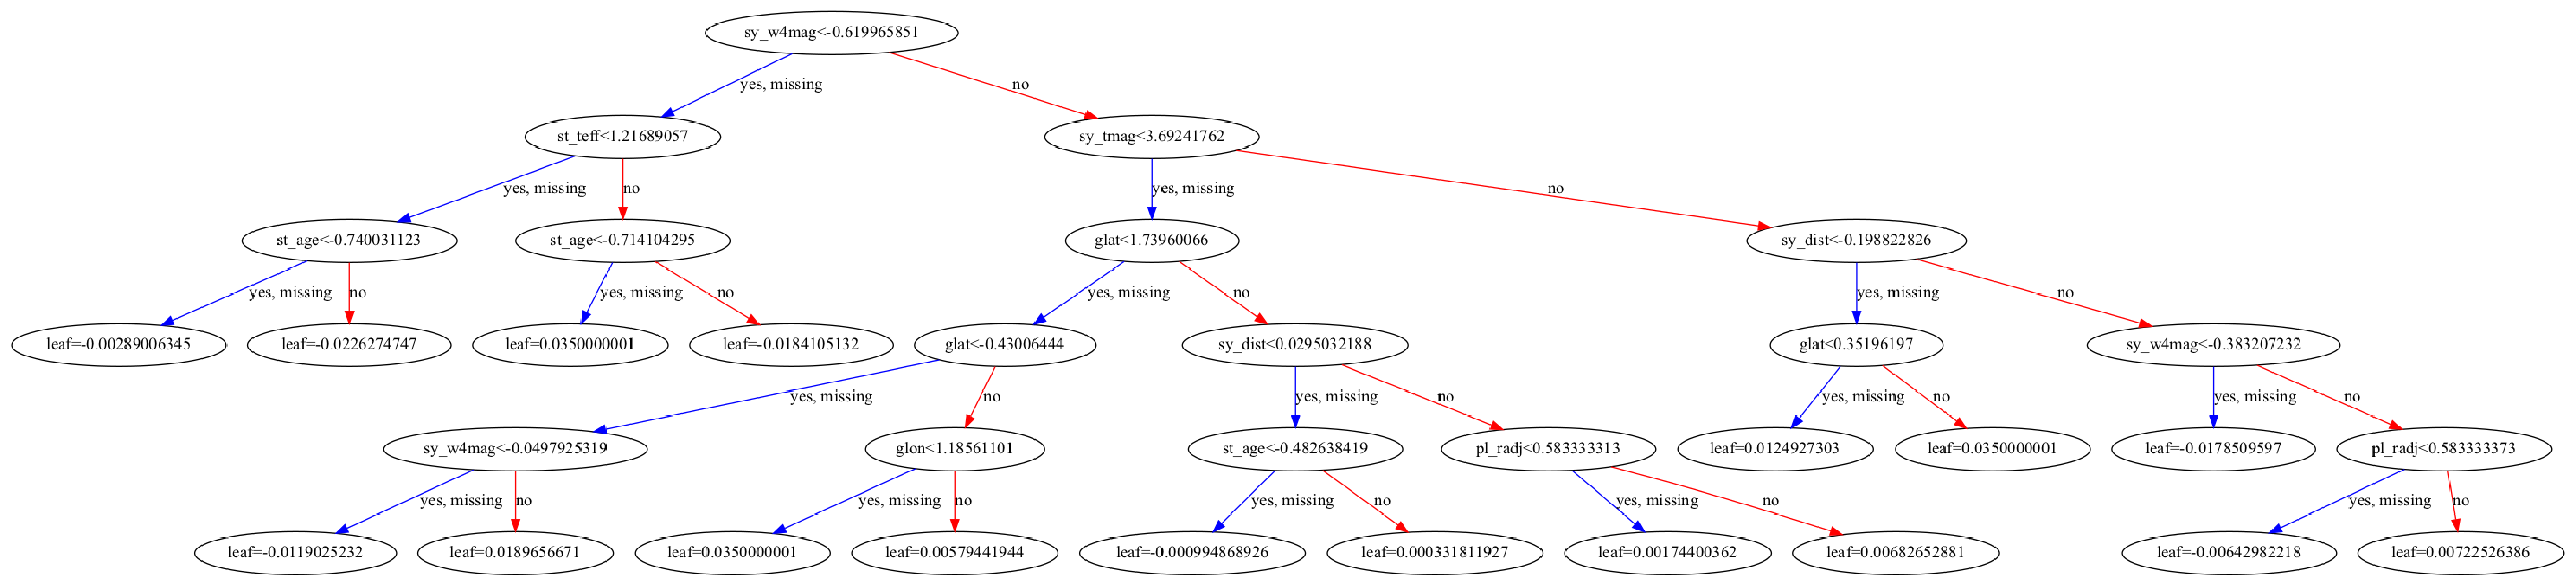

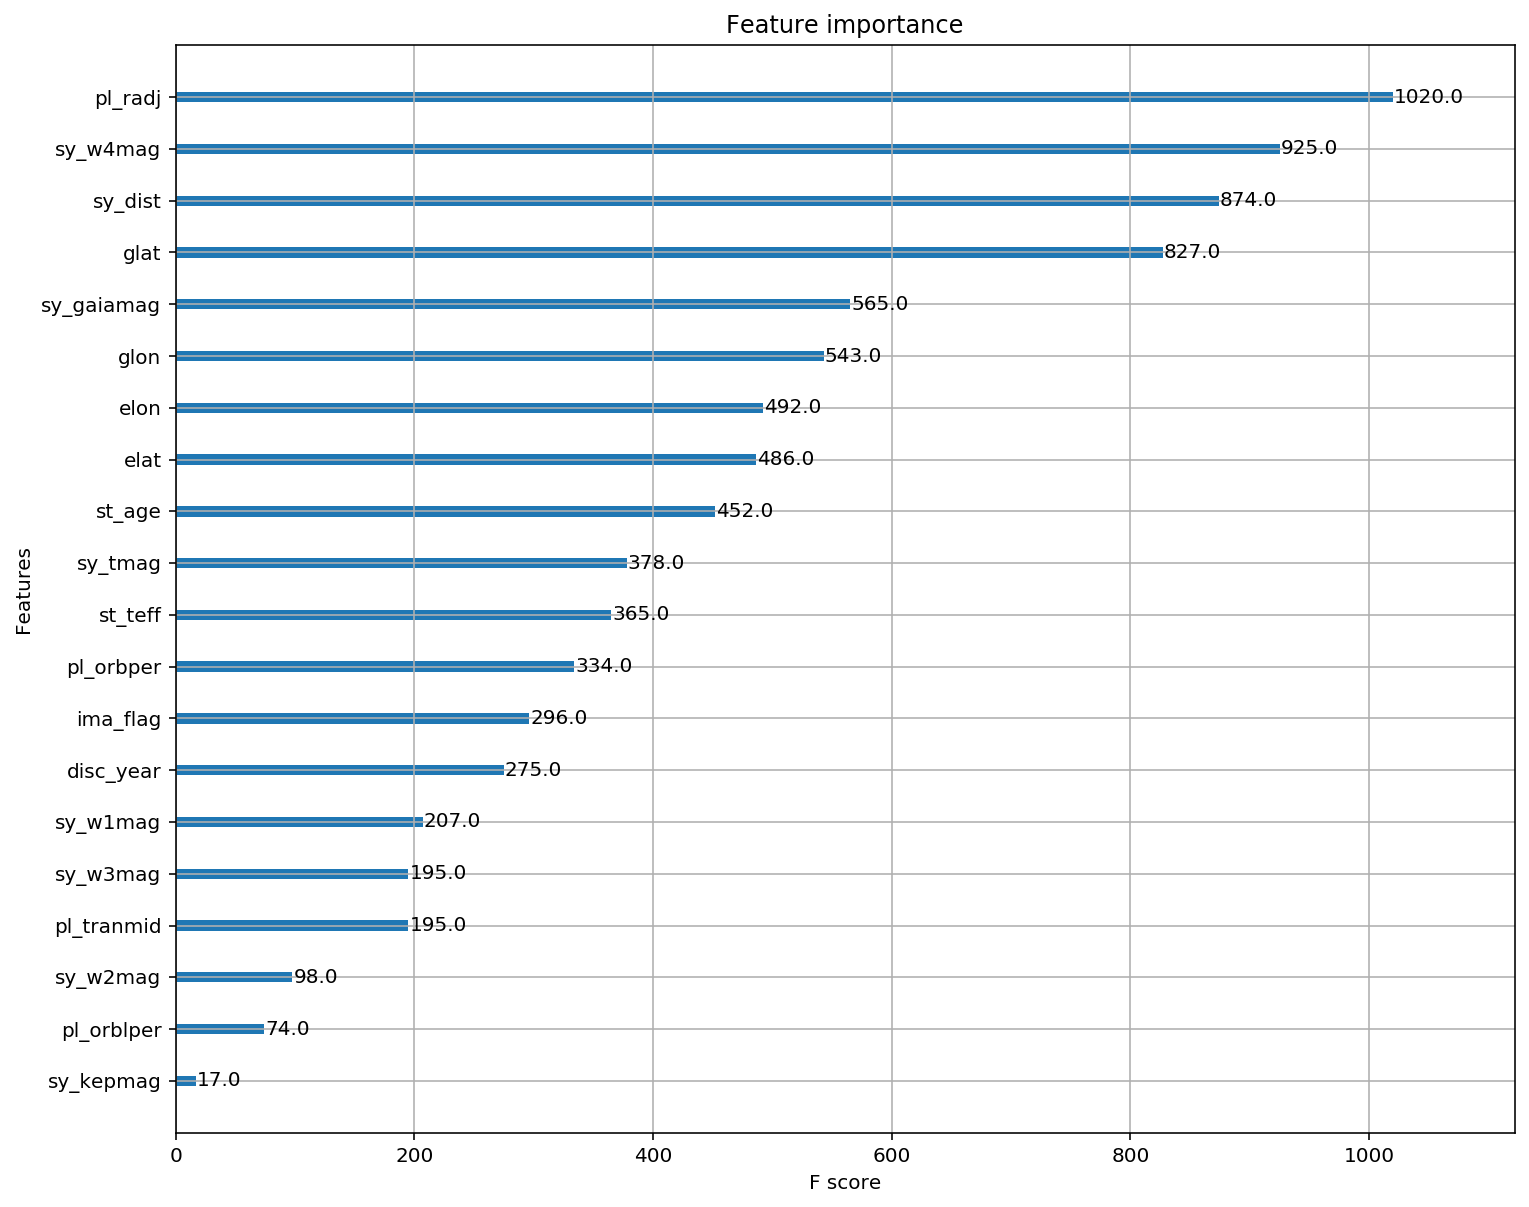

In [8]:
if override:
    pass
else:
    fig, ax = plt.subplots(figsize=(45,45))
    model = clf.named_steps.model.named_steps.crossValidation.best_estimator_
    model.get_booster().feature_names = features
    plot_tree(model.get_booster(), ax=ax)

    fig, ax = plt.subplots(figsize=(12,10))
    plot_importance(model.get_booster(), ax=ax)

# `Explaining the model`
## Prediction vs. Forecaster
- Display all the predicted values against the forecaster package, take the residuals of both and rank for `Prediction < Forecaster`.
- Then see how many times it takes for Forecaster to have a better accuracy than our prediction.

In [9]:
df = compare_predict_vs_test(raw_data, X_test, y_test, y_pred)

Predicting the Mass:

+--------------+---------+--------------+--------------+----------------------------+----------------------------+---------------------------+
| Planet       |    Test |   Prediction |   Forecaster |   Residual Test-Prediction |   Residual Test-Forecaster | Prediction < Forecaster   |
|--------------+---------+--------------+--------------+----------------------------+----------------------------+---------------------------|
| HAT-P-34 b   | 3.32800 |      4.09061 |      3.31539 |                    0.76261 |                    0.01261 | False                     |
| HD 209458 b  | 0.73000 |      0.79045 |      3.00234 |                    0.06045 |                    2.27234 | True                      |
| OGLE-TR-56 b | 0.90000 |      1.84105 |      2.68928 |                    0.94105 |                    1.78928 | True                      |
| HATS-2 b     | 1.53000 |      1.54071 |      3.70134 |                    0.01071 |                    2.17134 | True 

In [10]:
with suppress_print():
    df = compare_predict_vs_test(raw_data, X_test, y_test, y_pred)
    count = 0
    count_resid = 0
    while df['Prediction < Forecaster'].sum() > 7:
        df = compare_predict_vs_test(raw_data, X_test, y_test, y_pred)
        count += 1
        count_resid += df['Prediction < Forecaster'].sum()
print(f'It took {count} runs for Forecaster to beat the Regressor.')
print(f'Prediction beat Forecaster {count_resid}/{count*15} times.')

It took 28 runs for Forecaster to beat the Regressor.
Prediction beat Forecaster 297/420 times.


In [11]:
import eli5
perm = permutations()
if override:
    weights = eli5.show_weights(perm, feature_names = X_test.select_dtypes('number').columns.tolist())
else:
    weights = eli5.show_weights(perm, feature_names = X_test.columns.tolist())
    pass
weights

Weight,Feature
0.2801 ± 0.9268,elat
0.2763 ± 0.1837,pl_radj
0.2069 ± 0.0596,st_teff
0.1923 ± 0.0289,sy_w3mag
0.1306 ± 0.0418,sy_w2mag
0.1271 ± 0.0938,ima_flag
0.0847 ± 0.0734,pl_orbper
0.0649 ± 0.0258,sy_w1mag
0.0621 ± 0.0687,st_age
0.0545 ± 0.0427,glon


# `Shap Values`
Shap values show how much a given feature changed our prediction (compared to if we made that prediction at some baseline value of that feature). Permutation importance is great because it created simple numeric measures to see which features mattered to a model. This helped us make comparisons between features easily, and you can present the resulting graphs to non-technical audiences.

But it doesn't tell you how each features matter. If a feature has medium permutation importance, that could mean it has

- A large effect for a few predictions, but no effect in general, or
- A medium effect for all predictions.

In [12]:
import shap  
shap.initjs()
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X)
random_target = randrange(400)
print(f"Planet: {raw_data.iloc[random_target,:]['pl_name']}")
# Visualize the first prediction's explanation with a force plot
shap.force_plot(explainer.expected_value, shap_values[random_target,:], X.iloc[random_target,:])

Planet: EPIC 201357835.01


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


# Force plot
To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. SHAP values represent a feature's responsibility for a change in the model output.

In [13]:
# Visualize all the training set predictions
shap.force_plot(explainer.expected_value, shap_values[:400,:], X.iloc[:400,:])

# Summary Plot

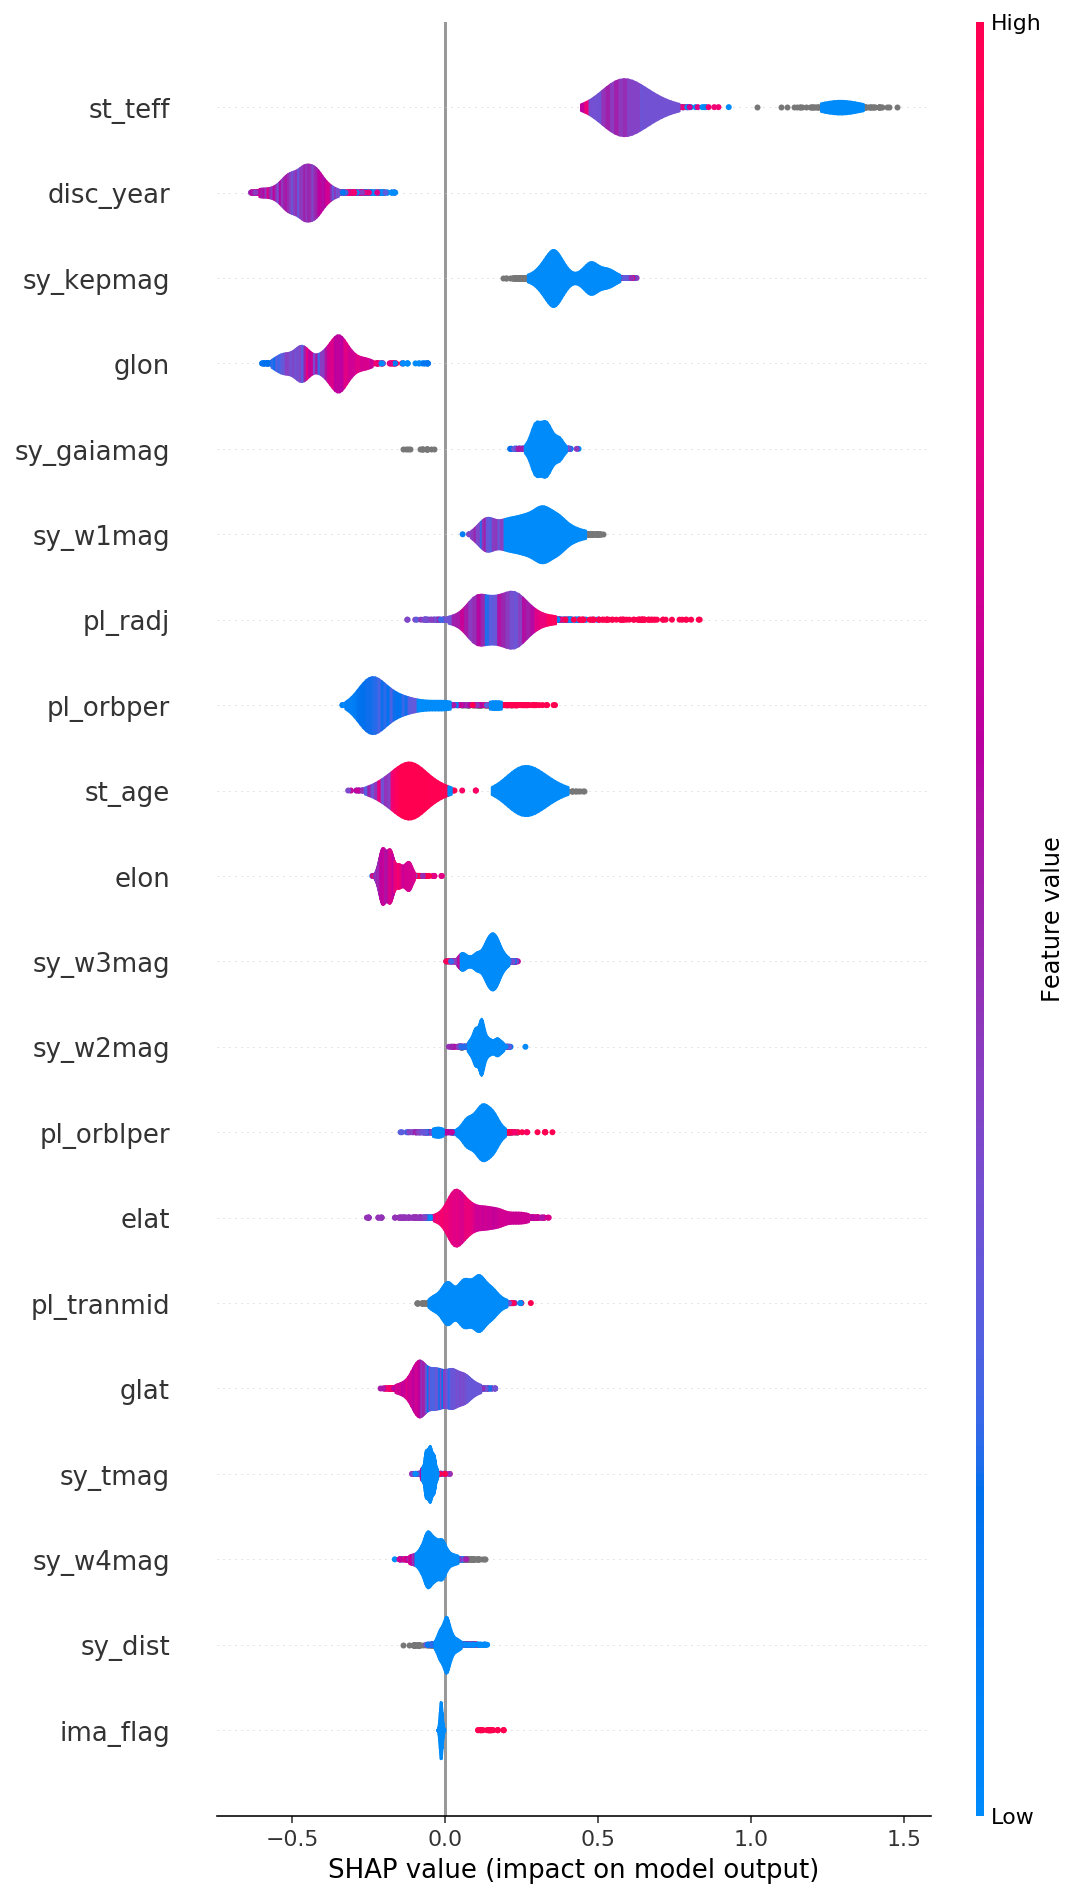

In [14]:
shap.summary_plot(shap_values, X, plot_size=0.75, plot_type='violin')

# Waterfall Plot
The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue. 

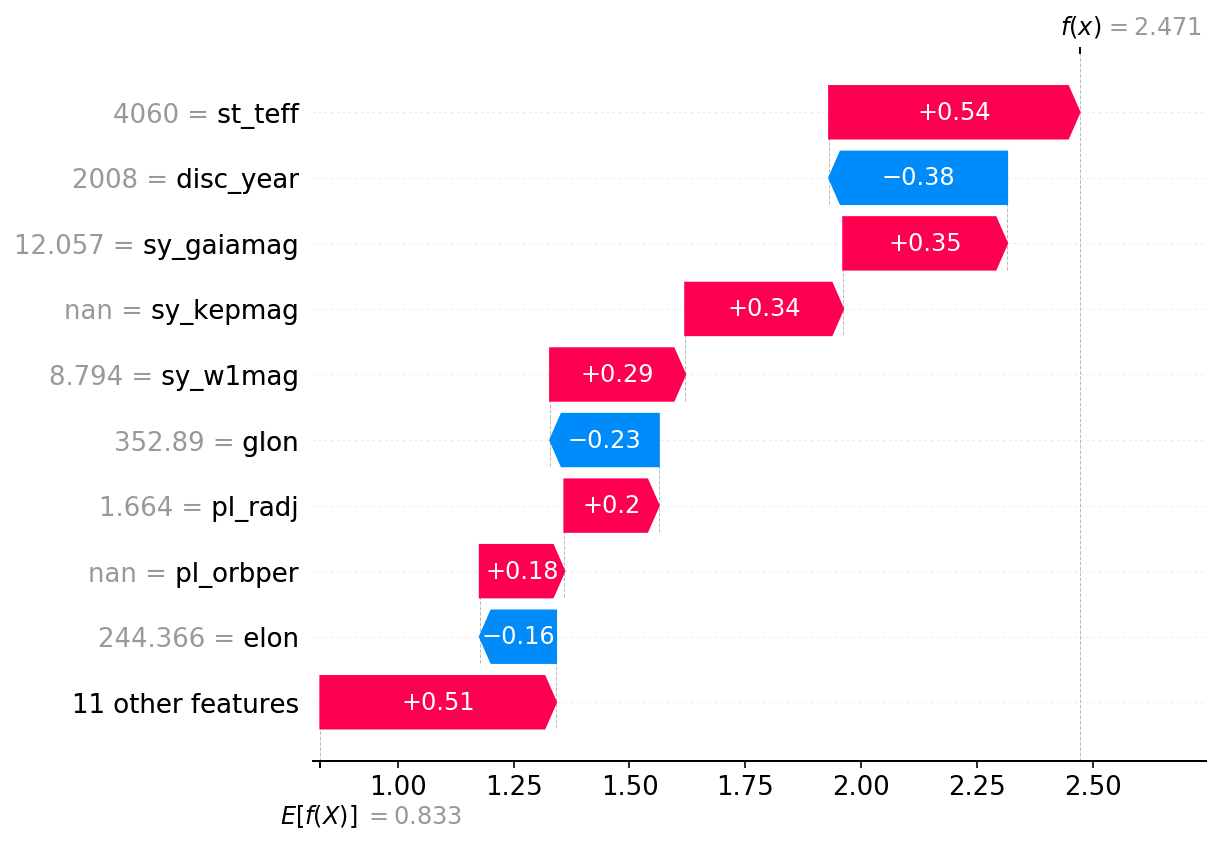

In [15]:
shap_items = explainer(X)
shap.plots.waterfall(shap_items[0])


To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). This reveals for example that a high LSTAT (% lower status of the population) lowers the predicted home price.

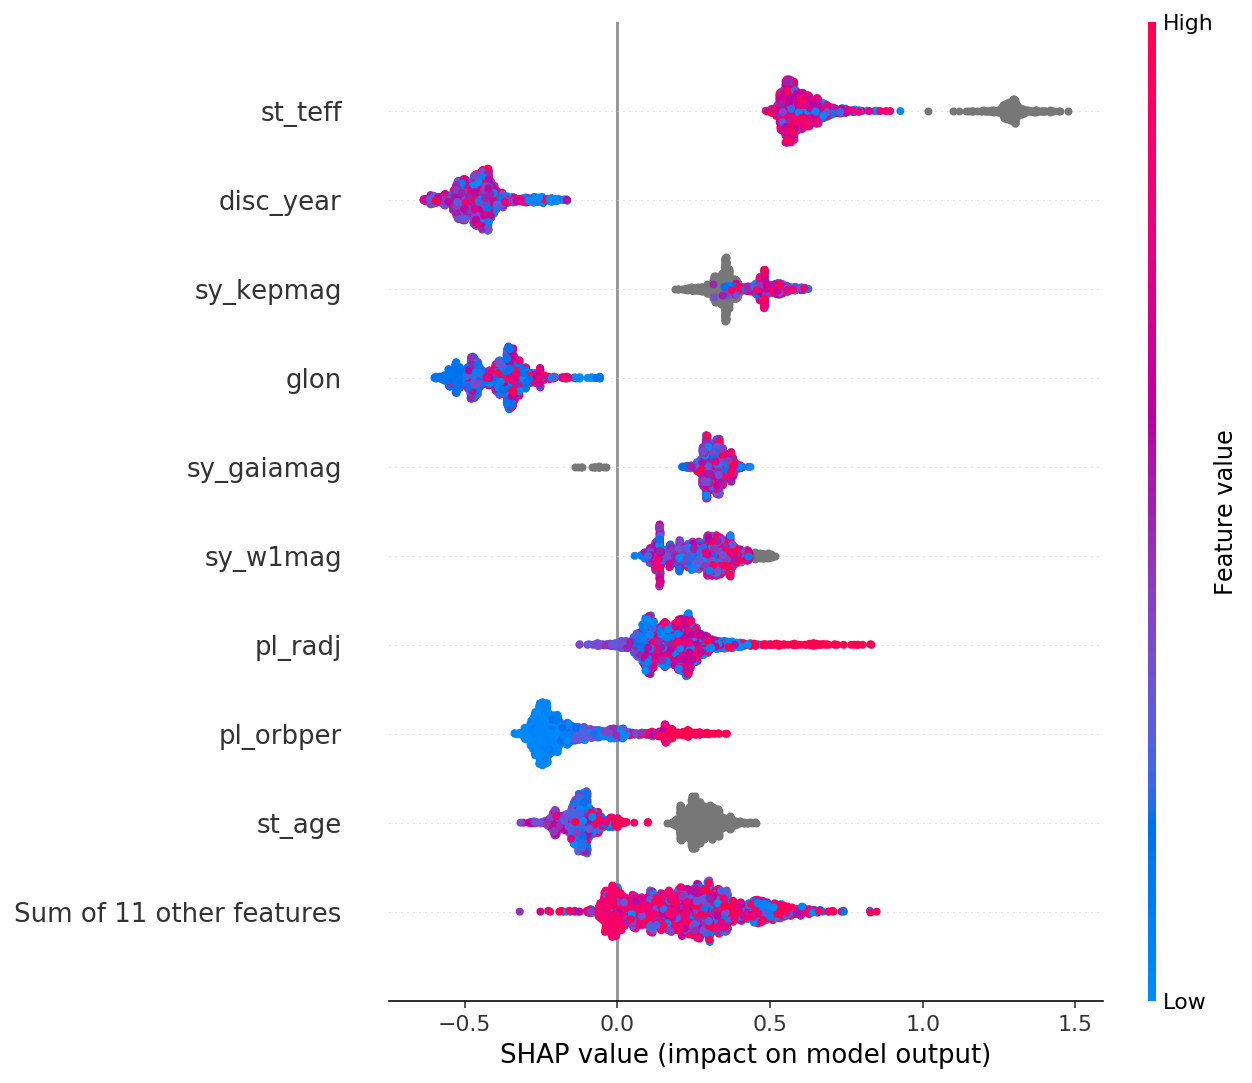

In [16]:
# Summarize the effects of all the features
shap.plots.beeswarm(shap_items, plot_size=0.75)

We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs):



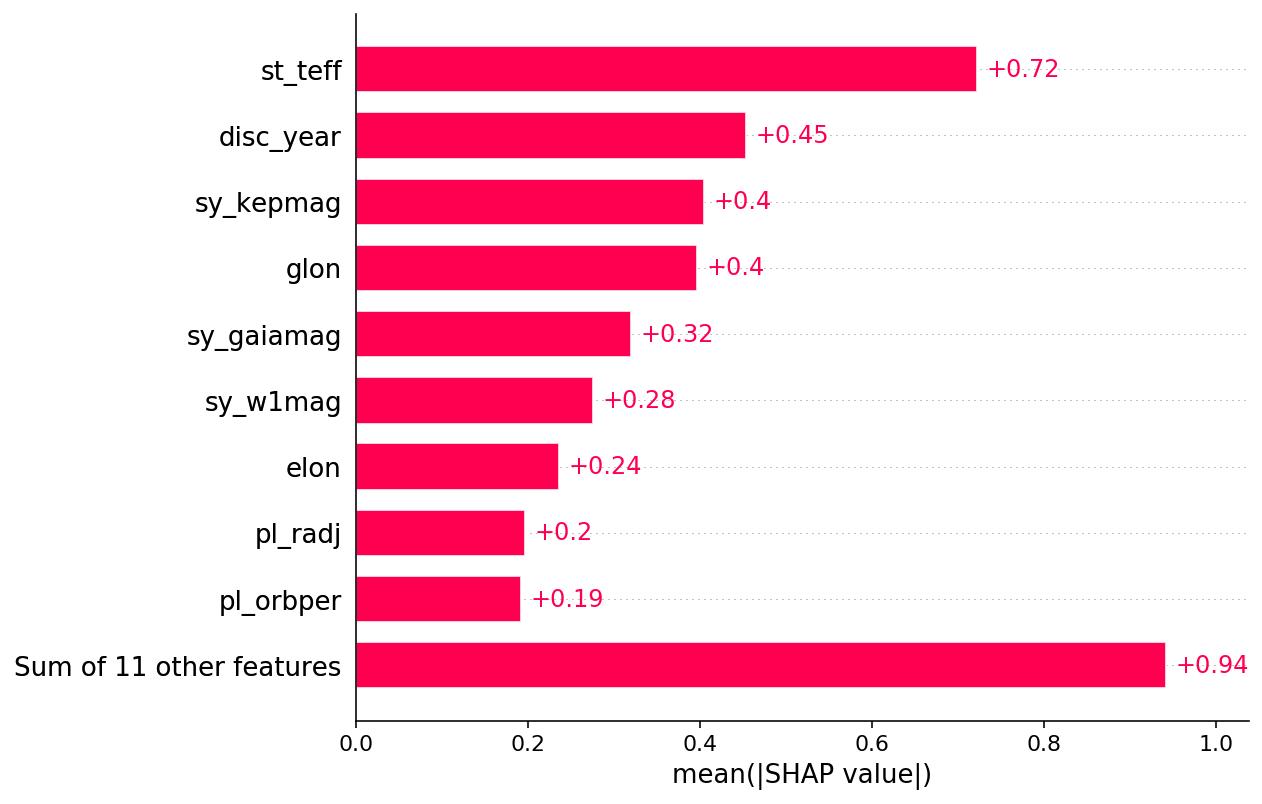

In [17]:
shap.plots.bar(shap_items)

Vertical dispersion at a single value of `pl_radj` represents interaction effects with other features. To help reveal these interactions we can color by another feature. If we pass the whole explanation tensor to the color argument the scatter plot will pick the best feature to color by. In this case it picks `pl_tranmid` since that highlights that the average planet radius has less impact on the planet mass with a high `pl_tranmid` value.

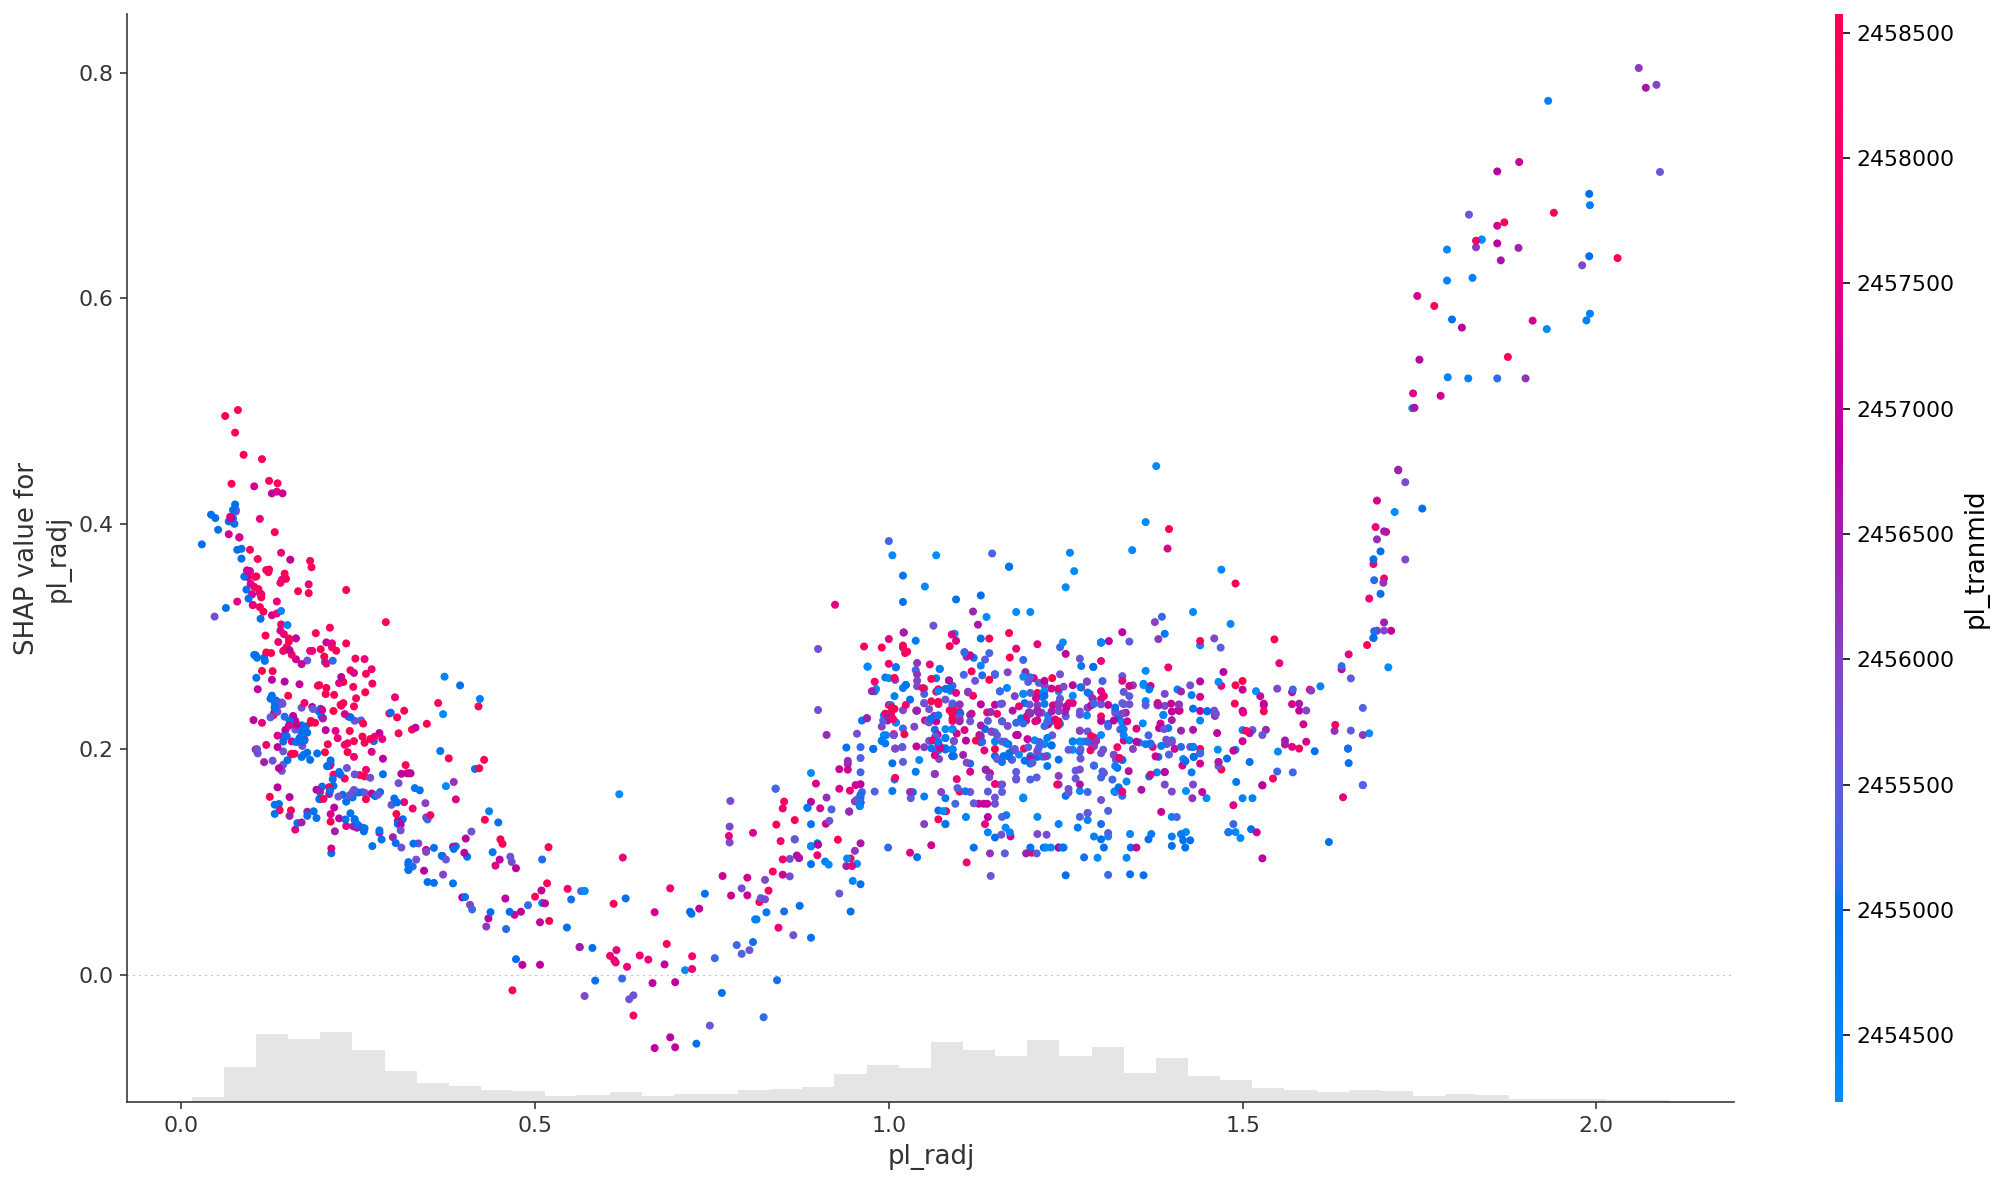

In [18]:
# Create a dependence scatter plot to show the effect of a single feature across the whole dataset
fix, ax = plt.subplots(figsize=(18,10))
shap.plots.scatter(shap_items[:,'pl_radj'], color=shap_items, ax=ax)

In [19]:
from aim.xgboost import AimCallback

# ...
aim_callback = AimCallback(repo='/path/to/logs/dir', experiment='experiment_name')
bst = xgb.train(param, xg_train, num_round, watchlist, callbacks=[aim_callback])
# ...

NameError: name 'xgb' is not defined